## Chassisml Example Notebooks
Welcome to the examples section for [Chassis.ml](https://chassis.ml), which contains notebooks that leverage Chassisml to auto-containerize models built using the most common machine learning frameworks. 

**NOTE:** Chassisml provides two key functionalities: 
1. Create a Docker container from your model code and push that container image to a Docker registry. This is the default behavior.
2. Should you pass valid Modzy credentials as optional parameters, Chassisml will take the container and upload it directly to the Modzy environment you specify. You will notice most of these notebooks deploy the model to one of the Modzy internal development environments.   

Can't find the framework you are looking for? Fork this repository and open a PR, we're always interested in growing this example bank! 

In [23]:
import os
import math
import json
import chassisml
import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from io import StringIO
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import norm

## Enter credentials
Dockerhub creds and Modzy API Key

In [3]:
dockerhub_user = getpass.getpass('docker hub username')
dockerhub_pass = getpass.getpass('docker hub password')
modzy_api_key = getpass.getpass('modzy api key')

docker hub username········
docker hub password········
modzy api key········


## Data Engineering

In [28]:
# load house price dataset
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (1460, 81), test: (1459, 80)


In [29]:
df_train.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1104,1105,160,RM,24.0,2016,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,TwnhsE,2Story,5,5,1970,1970,Gable,CompShg,HdBoard,HdBoard,BrkFace,304.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,630,630,GasA,TA,Y,SBrkr,630,672,0,1302,0,0,2,1,3,1,TA,6,Typ,0,NaN,Detchd,1970.0,Unf,2,440,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2007,WD,Normal,106000
180,181,160,FV,NaN,2117,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,6,5,2000,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,456.0,Gd,TA,PConc,Gd,TA,No,GLQ,436,Unf,0,320,756,GasA,Ex,Y,SBrkr,769,756,0,1525,0,0,2,1,3,1,Gd,5,Typ,1,TA,Detchd,2000.0,Unf,2,440,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,177000
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,2Story,10,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,1031.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1410,1410,GasA,Ex,Y,SBrkr,1426,1519,0,2945,0,0,3,1,3,1,Gd,10,Typ,1,Gd,BuiltIn,2006.0,Fin,3,641,TA,TA,Y,192,0,37,0,0,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780


In [30]:
# preprocess data
df_na = (df_train.isnull().sum() / len(df_train)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945
GarageQual,5.547945


C:\tools\Anaconda3\envs\chassis-demo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\tools\Anaconda3\envs\chassis-demo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

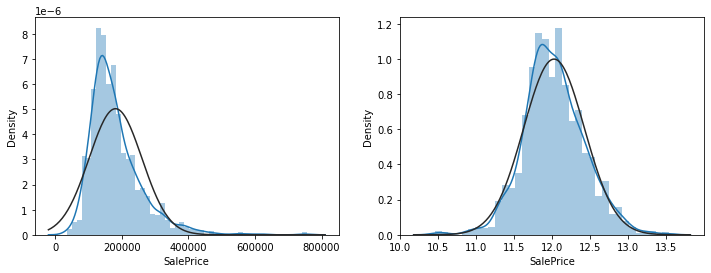

In [31]:
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(df_train['SalePrice'], ax=ax[0], fit=norm)
sns.distplot(np.log(df_train[('SalePrice')]+1), ax=ax[1], fit= norm)

In [32]:
def fill_missing(df, cols, val):
    """ Fill with the supplied val """
    for col in cols:
        df[col] = df[col].fillna(val)

def fill_missing_with_mode(df, cols):
    """ Fill with the mode """
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        
def addlogs(res, cols):
    """ Log transform feature list"""
    m = res.shape[1]
    for c in cols:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[c])).values)   
        res.columns.values[m] = c + '_log'
        m += 1
    return res

In [33]:
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
loglist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

df_train = addlogs(df_train, loglist)
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

In [34]:
fill_missing(df_train, ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                       "MasVnrType", "MSSubClass"], "None")
fill_missing(df_train, ["GarageYrBlt", "GarageArea", "GarageCars",
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                       "MasVnrArea"], 0)
fill_missing_with_mode(df_train, ["MSZoning", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"])
fill_missing(df_train, ["Functional"],"Typ")
# Utils is pointless as there is only one row with a value
df_train.drop(['Utilities'], axis=1, inplace=True)
# For lot frontage we take the median of the neighbourhood. In general this would be a good approximation as most 
# house co located are similar in size 
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [35]:
df_train.drop(df_train[(df_train['OverallQual']<5) & (df_train['SalePrice']>200000)].index, inplace=True)
df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)

In [36]:
def fix_missing_cols(in_train, in_test):
    missing_cols = set(in_train.columns) - set(in_test.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        in_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    in_test = in_test[in_train.columns]
    return in_test

def dummy_encode(in_df_train, in_df_test):
    df_train = in_df_train
    df_test = in_df_test
    categorical_feats = [
        f for f in df_train.columns if df_train[f].dtype == 'object'
    ]
    print(categorical_feats)
    for f_ in categorical_feats:
        prefix = f_
        df_train = pd.concat([df_train, pd.get_dummies(df_train[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = pd.concat([df_test, pd.get_dummies(df_test[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = fix_missing_cols(df_train, df_test)
    return df_train, df_test

In [37]:
df_train, df_test = dummy_encode(df_train, df_test)
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Shape train: (1456, 361), test: (1459, 361)


In [39]:
def load_poly_features(df_train, df_test, cols):
    """
    USeful function to generate poly terms
    :param df_train: The training data frame
    :param df_test: The test data frame
    :return: df_poly_features, df_poly_features_test - The training polynomial features + the test
    """
    print('Loading polynomial features..')
    # Make a new dataframe for polynomial features
    poly_features = df_train[cols]
    poly_features_test = df_test[cols]

    # imputer for handling missing values
    imputer = SimpleImputer(strategy='median')

    # Need to impute missing values
    poly_features = imputer.fit_transform(poly_features)
    poly_features_test = imputer.transform(poly_features_test)

    # Create the polynomial object with specified degree
    poly_transformer = PolynomialFeatures(degree=3)
    # Train the polynomial features
    poly_transformer.fit(poly_features)

    # Transform the features
    poly_features = poly_transformer.transform(poly_features)
    poly_features_test = poly_transformer.transform(poly_features_test)
    print('Polynomial Features shape: %s' % str(poly_features.shape))

    df_poly_features = pd.DataFrame(poly_features,
                                    columns=poly_transformer.get_feature_names(cols))
    df_poly_features_test = pd.DataFrame(poly_features_test,
                                         columns=poly_transformer.get_feature_names(cols))
    df_poly_features['Id'] = df_train['Id']
    df_poly_features_test['Id'] = df_test['Id']
    print('Loaded polynomial features')
    return df_poly_features, df_poly_features_test

In [40]:
correlated_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']
df_train_poly, df_test_poly =  load_poly_features(df_train, df_test, cols=correlated_cols)
print("Shape train: %s, test: %s" % (df_train_poly.shape, df_test_poly.shape))

Loading polynomial features..
Polynomial Features shape: (1456, 84)
Loaded polynomial features
Shape train: (1456, 85), test: (1459, 85)


C:\tools\Anaconda3\envs\chassis-demo\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
df_train = df_train.merge(right=df_train_poly.reset_index(), how='left', on='Id')
df_test = df_test.merge(right=df_test_poly.reset_index(), how='left', on='Id')
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (1456, 446), test: (1459, 446)


In [42]:
y = df_train["SalePrice"]
y.sample(3)

195     11.908347
1133    11.532738
398     11.112463
Name: SalePrice, dtype: float64

In [43]:
df_train.drop(["SalePrice"], axis=1, inplace=True)
# The fix missing cols above will have added the target column to the test data frame, so this is a workaround to remove it
df_test.drop(["SalePrice"], axis=1, inplace=True) 
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (1456, 445), test: (1459, 445)


In [45]:
X_train, X_test, y_train, y_test = train_test_split( df_train, y, test_size=0.2, random_state=42)
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [46]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [47]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

C:\tools\Anaconda3\envs\chassis-demo\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\tools\Anaconda3\envs\chassis-demo\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.9, col

[74]	valid_0's l1: 0.231388	valid_0's l2: 0.0904584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's l1: 0.23043	valid_0's l2: 0.0898488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's l1: 0.229481	valid_0's l2: 0.0892234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's l1: 0.22855	valid_0's l2: 0.0886174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's l1: 0.227619	valid_0's l2: 0.0880074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's l1: 0.226738	valid_0's l2: 0.0874145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's l1: 0.225846	valid_0's l2: 0.0868154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's l1: 0.224965	valid_0's l2: 0.0862325
[LightGBM] [Warning] No further splits with positive gain, be

[173]	valid_0's l1: 0.162961	valid_0's l2: 0.049783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's l1: 0.162494	valid_0's l2: 0.0495502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	valid_0's l1: 0.161966	valid_0's l2: 0.0492862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's l1: 0.161483	valid_0's l2: 0.0490498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's l1: 0.161023	valid_0's l2: 0.048824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	valid_0's l1: 0.160556	valid_0's l2: 0.0485975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[179]	valid_0's l1: 0.160058	valid_0's l2: 0.0483583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's l1: 0.159592	valid_0's l2: 0.0481299
[LightGBM] [Warning] No further splits with positive 

[269]	valid_0's l1: 0.12776	valid_0's l2: 0.0337599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	valid_0's l1: 0.127536	valid_0's l2: 0.0336585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's l1: 0.127332	valid_0's l2: 0.0335683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	valid_0's l1: 0.127126	valid_0's l2: 0.0334808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	valid_0's l1: 0.126925	valid_0's l2: 0.0333953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's l1: 0.126736	valid_0's l2: 0.0333141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's l1: 0.126549	valid_0's l2: 0.0332271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's l1: 0.126357	valid_0's l2: 0.0331407
[LightGBM] [Warning] No further splits with positive

[364]	valid_0's l1: 0.111453	valid_0's l2: 0.0267997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[365]	valid_0's l1: 0.11133	valid_0's l2: 0.0267457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[366]	valid_0's l1: 0.111204	valid_0's l2: 0.0266923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[367]	valid_0's l1: 0.111079	valid_0's l2: 0.0266384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[368]	valid_0's l1: 0.110962	valid_0's l2: 0.0265957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[369]	valid_0's l1: 0.110843	valid_0's l2: 0.0265444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's l1: 0.110725	valid_0's l2: 0.0264949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's l1: 0.110615	valid_0's l2: 0.0264455
[LightGBM] [Warning] No further splits with positive

[456]	valid_0's l1: 0.103321	valid_0's l2: 0.0235013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's l1: 0.103265	valid_0's l2: 0.0234776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[458]	valid_0's l1: 0.103225	valid_0's l2: 0.0234636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's l1: 0.103157	valid_0's l2: 0.0234406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[460]	valid_0's l1: 0.103075	valid_0's l2: 0.0234107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[461]	valid_0's l1: 0.103021	valid_0's l2: 0.0233926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[462]	valid_0's l1: 0.102959	valid_0's l2: 0.0233712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[463]	valid_0's l1: 0.102907	valid_0's l2: 0.0233514
[LightGBM] [Warning] No further splits with positiv

[522]	valid_0's l1: 0.100165	valid_0's l2: 0.0223466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[523]	valid_0's l1: 0.100111	valid_0's l2: 0.0223296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[524]	valid_0's l1: 0.100079	valid_0's l2: 0.0223159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[525]	valid_0's l1: 0.100037	valid_0's l2: 0.0223046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[526]	valid_0's l1: 0.0999965	valid_0's l2: 0.0222885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[527]	valid_0's l1: 0.0999572	valid_0's l2: 0.0222754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's l1: 0.0999242	valid_0's l2: 0.0222621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[529]	valid_0's l1: 0.099897	valid_0's l2: 0.0222486
[LightGBM] [Warning] No further splits with posi

[603]	valid_0's l1: 0.0974977	valid_0's l2: 0.0211866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's l1: 0.0974623	valid_0's l2: 0.0211729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's l1: 0.0974224	valid_0's l2: 0.0211586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's l1: 0.0973914	valid_0's l2: 0.0211443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's l1: 0.0973593	valid_0's l2: 0.0211312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's l1: 0.0973205	valid_0's l2: 0.0211142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's l1: 0.097278	valid_0's l2: 0.0210969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's l1: 0.0972433	valid_0's l2: 0.0210848
[LightGBM] [Warning] No further splits with 

[668]	valid_0's l1: 0.0956821	valid_0's l2: 0.020469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[669]	valid_0's l1: 0.0956452	valid_0's l2: 0.0204522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[670]	valid_0's l1: 0.0956242	valid_0's l2: 0.0204444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	valid_0's l1: 0.0956164	valid_0's l2: 0.0204382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	valid_0's l1: 0.0956084	valid_0's l2: 0.0204329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	valid_0's l1: 0.0955799	valid_0's l2: 0.0204289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	valid_0's l1: 0.0955464	valid_0's l2: 0.0204232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	valid_0's l1: 0.0955136	valid_0's l2: 0.0204177
[LightGBM] [Warning] No further splits with 

[743]	valid_0's l1: 0.0942653	valid_0's l2: 0.0199448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	valid_0's l1: 0.0942522	valid_0's l2: 0.0199419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's l1: 0.0942401	valid_0's l2: 0.0199392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's l1: 0.0942248	valid_0's l2: 0.0199323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's l1: 0.0942172	valid_0's l2: 0.0199301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[748]	valid_0's l1: 0.0942012	valid_0's l2: 0.0199234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[749]	valid_0's l1: 0.0941902	valid_0's l2: 0.0199215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's l1: 0.0941732	valid_0's l2: 0.0199152
[LightGBM] [Warning] No further splits with

[827]	valid_0's l1: 0.0932699	valid_0's l2: 0.0195803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[828]	valid_0's l1: 0.0932656	valid_0's l2: 0.0195805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[829]	valid_0's l1: 0.0932671	valid_0's l2: 0.0195814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[830]	valid_0's l1: 0.0932623	valid_0's l2: 0.01958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[831]	valid_0's l1: 0.0932592	valid_0's l2: 0.0195808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[832]	valid_0's l1: 0.0932566	valid_0's l2: 0.0195817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[833]	valid_0's l1: 0.0932572	valid_0's l2: 0.0195824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[834]	valid_0's l1: 0.0932518	valid_0's l2: 0.0195825
[LightGBM] [Warning] No further splits with p

[900]	valid_0's l1: 0.0926463	valid_0's l2: 0.0193713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[901]	valid_0's l1: 0.092653	valid_0's l2: 0.0193725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[902]	valid_0's l1: 0.0926576	valid_0's l2: 0.0193746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[903]	valid_0's l1: 0.0926569	valid_0's l2: 0.0193764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[904]	valid_0's l1: 0.0926512	valid_0's l2: 0.0193746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[905]	valid_0's l1: 0.0926579	valid_0's l2: 0.0193759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[906]	valid_0's l1: 0.0926617	valid_0's l2: 0.0193784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[907]	valid_0's l1: 0.0926692	valid_0's l2: 0.0193789
[LightGBM] [Warning] No further splits with 

[982]	valid_0's l1: 0.0921434	valid_0's l2: 0.0191548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	valid_0's l1: 0.0921371	valid_0's l2: 0.0191539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	valid_0's l1: 0.0921366	valid_0's l2: 0.0191551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	valid_0's l1: 0.0921397	valid_0's l2: 0.0191574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's l1: 0.0921367	valid_0's l2: 0.0191552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[987]	valid_0's l1: 0.092138	valid_0's l2: 0.0191566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's l1: 0.0921432	valid_0's l2: 0.0191596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's l1: 0.0921361	valid_0's l2: 0.0191576
[LightGBM] [Warning] No further splits with 

[1071]	valid_0's l1: 0.0918059	valid_0's l2: 0.0190388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1072]	valid_0's l1: 0.0918063	valid_0's l2: 0.0190384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1073]	valid_0's l1: 0.0918095	valid_0's l2: 0.0190384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1074]	valid_0's l1: 0.0918118	valid_0's l2: 0.0190372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1075]	valid_0's l1: 0.0918001	valid_0's l2: 0.0190354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1076]	valid_0's l1: 0.0918035	valid_0's l2: 0.0190347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1077]	valid_0's l1: 0.0918054	valid_0's l2: 0.0190335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1078]	valid_0's l1: 0.0918021	valid_0's l2: 0.0190325
[LightGBM] [Warning] No further spl

[1139]	valid_0's l1: 0.0914551	valid_0's l2: 0.0189225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1140]	valid_0's l1: 0.0914577	valid_0's l2: 0.0189245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1141]	valid_0's l1: 0.0914547	valid_0's l2: 0.0189278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1142]	valid_0's l1: 0.0914451	valid_0's l2: 0.0189285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's l1: 0.0914389	valid_0's l2: 0.0189306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1144]	valid_0's l1: 0.0914444	valid_0's l2: 0.0189345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1145]	valid_0's l1: 0.0914382	valid_0's l2: 0.0189368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1146]	valid_0's l1: 0.091442	valid_0's l2: 0.0189383
[LightGBM] [Warning] No further spli

[1209]	valid_0's l1: 0.0914608	valid_0's l2: 0.0189206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1210]	valid_0's l1: 0.0914575	valid_0's l2: 0.0189215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1211]	valid_0's l1: 0.0914519	valid_0's l2: 0.0189196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1212]	valid_0's l1: 0.0914474	valid_0's l2: 0.0189184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1213]	valid_0's l1: 0.0914284	valid_0's l2: 0.0189135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1214]	valid_0's l1: 0.091439	valid_0's l2: 0.0189169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1215]	valid_0's l1: 0.0914357	valid_0's l2: 0.0189162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1216]	valid_0's l1: 0.0914342	valid_0's l2: 0.018915
[LightGBM] [Warning] No further split

[1297]	valid_0's l1: 0.0911198	valid_0's l2: 0.0187149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1298]	valid_0's l1: 0.0911113	valid_0's l2: 0.0187108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1299]	valid_0's l1: 0.0911015	valid_0's l2: 0.0187067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1300]	valid_0's l1: 0.0911013	valid_0's l2: 0.0187051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1301]	valid_0's l1: 0.0911038	valid_0's l2: 0.0187058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1302]	valid_0's l1: 0.0910981	valid_0's l2: 0.0187033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1303]	valid_0's l1: 0.091109	valid_0's l2: 0.0187062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1304]	valid_0's l1: 0.0911007	valid_0's l2: 0.0187024
[LightGBM] [Warning] No further spli

[1391]	valid_0's l1: 0.0909285	valid_0's l2: 0.0186406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1392]	valid_0's l1: 0.0909444	valid_0's l2: 0.0186452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1393]	valid_0's l1: 0.0909603	valid_0's l2: 0.0186499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1394]	valid_0's l1: 0.0909679	valid_0's l2: 0.0186518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1395]	valid_0's l1: 0.0909718	valid_0's l2: 0.0186534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1396]	valid_0's l1: 0.0909854	valid_0's l2: 0.0186573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1397]	valid_0's l1: 0.0909917	valid_0's l2: 0.0186599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1398]	valid_0's l1: 0.0909972	valid_0's l2: 0.01866
[LightGBM] [Warning] No further split

[1483]	valid_0's l1: 0.0909256	valid_0's l2: 0.0186207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1484]	valid_0's l1: 0.0909277	valid_0's l2: 0.0186217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1485]	valid_0's l1: 0.0909231	valid_0's l2: 0.0186212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1486]	valid_0's l1: 0.0909188	valid_0's l2: 0.0186209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1487]	valid_0's l1: 0.0909149	valid_0's l2: 0.0186207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1488]	valid_0's l1: 0.0909162	valid_0's l2: 0.0186202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1489]	valid_0's l1: 0.0909119	valid_0's l2: 0.01862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1490]	valid_0's l1: 0.0909081	valid_0's l2: 0.0186196
[LightGBM] [Warning] No further split

[1566]	valid_0's l1: 0.0903417	valid_0's l2: 0.0185102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1567]	valid_0's l1: 0.0903384	valid_0's l2: 0.0185094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1568]	valid_0's l1: 0.0903318	valid_0's l2: 0.0185095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1569]	valid_0's l1: 0.0903231	valid_0's l2: 0.0185077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1570]	valid_0's l1: 0.0903241	valid_0's l2: 0.0185088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1571]	valid_0's l1: 0.0903308	valid_0's l2: 0.0185122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1572]	valid_0's l1: 0.0903316	valid_0's l2: 0.0185119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1573]	valid_0's l1: 0.0903332	valid_0's l2: 0.0185119
[LightGBM] [Warning] No further spl

[1657]	valid_0's l1: 0.089985	valid_0's l2: 0.0183609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1658]	valid_0's l1: 0.0899884	valid_0's l2: 0.0183632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1659]	valid_0's l1: 0.0899831	valid_0's l2: 0.018361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1660]	valid_0's l1: 0.0899712	valid_0's l2: 0.0183564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1661]	valid_0's l1: 0.0899677	valid_0's l2: 0.0183554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1662]	valid_0's l1: 0.0899623	valid_0's l2: 0.0183538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1663]	valid_0's l1: 0.0899565	valid_0's l2: 0.0183523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1664]	valid_0's l1: 0.0899508	valid_0's l2: 0.0183508
[LightGBM] [Warning] No further split

[1739]	valid_0's l1: 0.0897723	valid_0's l2: 0.0182835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1740]	valid_0's l1: 0.0897643	valid_0's l2: 0.0182812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1741]	valid_0's l1: 0.0897631	valid_0's l2: 0.0182808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1742]	valid_0's l1: 0.0897645	valid_0's l2: 0.0182806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1743]	valid_0's l1: 0.089769	valid_0's l2: 0.0182816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1744]	valid_0's l1: 0.0897715	valid_0's l2: 0.018282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1745]	valid_0's l1: 0.0897682	valid_0's l2: 0.0182822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1746]	valid_0's l1: 0.089772	valid_0's l2: 0.0182824
[LightGBM] [Warning] No further splits

[1833]	valid_0's l1: 0.089674	valid_0's l2: 0.0182554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1834]	valid_0's l1: 0.0896734	valid_0's l2: 0.0182547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1835]	valid_0's l1: 0.0896741	valid_0's l2: 0.0182582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1836]	valid_0's l1: 0.089674	valid_0's l2: 0.0182575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1837]	valid_0's l1: 0.0896739	valid_0's l2: 0.0182569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1838]	valid_0's l1: 0.0896739	valid_0's l2: 0.0182562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1839]	valid_0's l1: 0.0896762	valid_0's l2: 0.0182565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1840]	valid_0's l1: 0.0896786	valid_0's l2: 0.0182559
[LightGBM] [Warning] No further split

[1911]	valid_0's l1: 0.0895733	valid_0's l2: 0.0183006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1912]	valid_0's l1: 0.089575	valid_0's l2: 0.0182989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1913]	valid_0's l1: 0.0895755	valid_0's l2: 0.0182975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1914]	valid_0's l1: 0.089578	valid_0's l2: 0.0182967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1915]	valid_0's l1: 0.0895788	valid_0's l2: 0.018295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1916]	valid_0's l1: 0.0895804	valid_0's l2: 0.018294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1917]	valid_0's l1: 0.0895829	valid_0's l2: 0.018293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1918]	valid_0's l1: 0.0895862	valid_0's l2: 0.0182926
[LightGBM] [Warning] No further splits w

[2000]	valid_0's l1: 0.0896504	valid_0's l2: 0.0182804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2001]	valid_0's l1: 0.0896415	valid_0's l2: 0.0182782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2002]	valid_0's l1: 0.0896386	valid_0's l2: 0.0182783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2003]	valid_0's l1: 0.0896308	valid_0's l2: 0.0182771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2004]	valid_0's l1: 0.0896192	valid_0's l2: 0.0182736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2005]	valid_0's l1: 0.0896083	valid_0's l2: 0.0182709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2006]	valid_0's l1: 0.0896003	valid_0's l2: 0.0182686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2007]	valid_0's l1: 0.089591	valid_0's l2: 0.018266
[LightGBM] [Warning] No further split

[2090]	valid_0's l1: 0.0892563	valid_0's l2: 0.0181131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2091]	valid_0's l1: 0.0892522	valid_0's l2: 0.0181131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2092]	valid_0's l1: 0.0892457	valid_0's l2: 0.0181122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2093]	valid_0's l1: 0.0892516	valid_0's l2: 0.0181138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2094]	valid_0's l1: 0.0892485	valid_0's l2: 0.0181134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2095]	valid_0's l1: 0.089243	valid_0's l2: 0.0181123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2096]	valid_0's l1: 0.0892476	valid_0's l2: 0.0181134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2097]	valid_0's l1: 0.0892421	valid_0's l2: 0.0181124
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2176]	valid_0's l1: 0.0889059	valid_0's l2: 0.0180542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2177]	valid_0's l1: 0.0889118	valid_0's l2: 0.0180565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2178]	valid_0's l1: 0.0889138	valid_0's l2: 0.0180587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2179]	valid_0's l1: 0.0889073	valid_0's l2: 0.0180583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2180]	valid_0's l1: 0.0889101	valid_0's l2: 0.0180597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2181]	valid_0's l1: 0.0889132	valid_0's l2: 0.0180612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2182]	valid_0's l1: 0.0889123	valid_0's l2: 0.0180633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2183]	valid_0'

[2242]	valid_0's l1: 0.0887129	valid_0's l2: 0.0180413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2243]	valid_0's l1: 0.0887082	valid_0's l2: 0.0180416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2244]	valid_0's l1: 0.0887042	valid_0's l2: 0.0180417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2245]	valid_0's l1: 0.0886996	valid_0's l2: 0.0180422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2246]	valid_0's l1: 0.0886956	valid_0's l2: 0.0180424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2247]	valid_0's l1: 0.0886929	valid_0's l2: 0.0180431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2248]	valid_0's l1: 0.0886884	valid_0's l2: 0.0180435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2249]	valid_0's l1: 0.0886854	valid_0's l2: 0.0180446
[LightGBM] [Warning] No further spl

[2323]	valid_0's l1: 0.0888818	valid_0's l2: 0.0180714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2324]	valid_0's l1: 0.0888846	valid_0's l2: 0.0180711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2325]	valid_0's l1: 0.0888913	valid_0's l2: 0.0180714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2326]	valid_0's l1: 0.0888969	valid_0's l2: 0.0180729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2327]	valid_0's l1: 0.0888937	valid_0's l2: 0.0180721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2328]	valid_0's l1: 0.0888945	valid_0's l2: 0.0180714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2329]	valid_0's l1: 0.0888999	valid_0's l2: 0.0180734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2330]	valid_0's l1: 0.0888975	valid_0's l2: 0.018073
[LightGBM] [Warning] No further spli

[2400]	valid_0's l1: 0.0888399	valid_0's l2: 0.0180503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2401]	valid_0's l1: 0.0888334	valid_0's l2: 0.0180469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2402]	valid_0's l1: 0.0888288	valid_0's l2: 0.0180441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2403]	valid_0's l1: 0.0888222	valid_0's l2: 0.0180409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2404]	valid_0's l1: 0.0888158	valid_0's l2: 0.0180376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2405]	valid_0's l1: 0.0888024	valid_0's l2: 0.0180328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2406]	valid_0's l1: 0.0887892	valid_0's l2: 0.0180286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2407]	valid_0's l1: 0.0887839	valid_0's l2: 0.0180255
[LightGBM] [Warning] No further spl

[2479]	valid_0's l1: 0.0886691	valid_0's l2: 0.018008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2480]	valid_0's l1: 0.0886682	valid_0's l2: 0.0180081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2481]	valid_0's l1: 0.08867	valid_0's l2: 0.0180093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2482]	valid_0's l1: 0.0886693	valid_0's l2: 0.0180104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2483]	valid_0's l1: 0.088671	valid_0's l2: 0.0180115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2484]	valid_0's l1: 0.0886727	valid_0's l2: 0.0180133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2485]	valid_0's l1: 0.0886802	valid_0's l2: 0.0180153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2486]	valid_0's l1: 0.0886884	valid_0's l2: 0.0180163
[LightGBM] [Warning] No further splits 

[2562]	valid_0's l1: 0.0886844	valid_0's l2: 0.0180287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2563]	valid_0's l1: 0.0886801	valid_0's l2: 0.0180279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2564]	valid_0's l1: 0.0886692	valid_0's l2: 0.0180251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2565]	valid_0's l1: 0.0886569	valid_0's l2: 0.0180227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2566]	valid_0's l1: 0.0886469	valid_0's l2: 0.0180206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2567]	valid_0's l1: 0.088636	valid_0's l2: 0.0180175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2568]	valid_0's l1: 0.0886267	valid_0's l2: 0.0180156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2569]	valid_0's l1: 0.0886179	valid_0's l2: 0.0180135
[LightGBM] [Warning] No further spli

[2641]	valid_0's l1: 0.0886386	valid_0's l2: 0.0180082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2642]	valid_0's l1: 0.0886368	valid_0's l2: 0.0180067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2643]	valid_0's l1: 0.0886356	valid_0's l2: 0.0180067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2644]	valid_0's l1: 0.0886335	valid_0's l2: 0.0180052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2645]	valid_0's l1: 0.0886335	valid_0's l2: 0.0180049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2646]	valid_0's l1: 0.0886316	valid_0's l2: 0.0180037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2647]	valid_0's l1: 0.0886309	valid_0's l2: 0.0180036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2648]	valid_0's l1: 0.0886302	valid_0's l2: 0.0180036
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2745]	valid_0's l1: 0.0887557	valid_0's l2: 0.0179949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2746]	valid_0's l1: 0.0887541	valid_0's l2: 0.0179948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2747]	valid_0's l1: 0.0887538	valid_0's l2: 0.0179956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2748]	valid_0's l1: 0.088751	valid_0's l2: 0.0179961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2749]	valid_0's l1: 0.0887534	valid_0's l2: 0.0179985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2750]	valid_0's l1: 0.0887526	valid_0's l2: 0.0179987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2751]	valid_0's l1: 0.08876	valid_0's l2: 0.0180018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2752]	valid_0's l

[2821]	valid_0's l1: 0.0887791	valid_0's l2: 0.0180206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2822]	valid_0's l1: 0.0887788	valid_0's l2: 0.0180205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2823]	valid_0's l1: 0.0887834	valid_0's l2: 0.0180214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2824]	valid_0's l1: 0.0887822	valid_0's l2: 0.0180213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2825]	valid_0's l1: 0.0887856	valid_0's l2: 0.018022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2826]	valid_0's l1: 0.0887871	valid_0's l2: 0.0180227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2827]	valid_0's l1: 0.0887886	valid_0's l2: 0.0180236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2828]	valid_0's l1: 0.088788	valid_0's l2: 0.0180228
[LightGBM] [Warning] No further split

[2916]	valid_0's l1: 0.0886491	valid_0's l2: 0.0179759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2917]	valid_0's l1: 0.0886491	valid_0's l2: 0.0179754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2918]	valid_0's l1: 0.0886492	valid_0's l2: 0.0179746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2919]	valid_0's l1: 0.0886486	valid_0's l2: 0.0179741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2920]	valid_0's l1: 0.0886487	valid_0's l2: 0.0179733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2921]	valid_0's l1: 0.0886505	valid_0's l2: 0.0179732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2922]	valid_0's l1: 0.088652	valid_0's l2: 0.0179729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2923]	valid_0's l1: 0.0886527	valid_0's l2: 0.0179723
[LightGBM] [Warning] No further spli

[2995]	valid_0's l1: 0.088619	valid_0's l2: 0.0179599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2996]	valid_0's l1: 0.0886169	valid_0's l2: 0.0179602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2997]	valid_0's l1: 0.08862	valid_0's l2: 0.0179618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2998]	valid_0's l1: 0.0886213	valid_0's l2: 0.0179629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2999]	valid_0's l1: 0.0886232	valid_0's l2: 0.0179643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's l1: 0.0886211	valid_0's l2: 0.0179641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3001]	valid_0's l1: 0.0886203	valid_0's l2: 0.0179648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3002]	valid_0's l1: 0.0886185	valid_0's l2: 0.0179655
[LightGBM] [Warning] No further splits

[3066]	valid_0's l1: 0.0886039	valid_0's l2: 0.0179826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3067]	valid_0's l1: 0.0886077	valid_0's l2: 0.0179831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3068]	valid_0's l1: 0.0886098	valid_0's l2: 0.017984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3069]	valid_0's l1: 0.0886177	valid_0's l2: 0.017985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3070]	valid_0's l1: 0.0886197	valid_0's l2: 0.0179858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3071]	valid_0's l1: 0.0886223	valid_0's l2: 0.0179871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3072]	valid_0's l1: 0.0886223	valid_0's l2: 0.0179875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3073]	valid_0's l1: 0.0886243	valid_0's l2: 0.0179895
[LightGBM] [Warning] No further split

[3151]	valid_0's l1: 0.0885937	valid_0's l2: 0.0180032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3152]	valid_0's l1: 0.088594	valid_0's l2: 0.0180014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3153]	valid_0's l1: 0.0885982	valid_0's l2: 0.0180008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3154]	valid_0's l1: 0.0885995	valid_0's l2: 0.0180011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3155]	valid_0's l1: 0.0886038	valid_0's l2: 0.018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3156]	valid_0's l1: 0.0886038	valid_0's l2: 0.0179996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3157]	valid_0's l1: 0.0886062	valid_0's l2: 0.0179985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3158]	valid_0's l1: 0.0886058	valid_0's l2: 0.0179989
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3219]	valid_0's l1: 0.0886128	valid_0's l2: 0.0180054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3220]	valid_0's l1: 0.0886103	valid_0's l2: 0.0180047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3221]	valid_0's l1: 0.0886073	valid_0's l2: 0.0180032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3222]	valid_0's l1: 0.0886072	valid_0's l2: 0.0180025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3223]	valid_0's l1: 0.0886066	valid_0's l2: 0.0180017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3224]	valid_0's l1: 0.0886073	valid_0's l2: 0.0180011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3225]	valid_0's l1: 0.0886072	valid_0's l2: 0.0180006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3226]	valid_0'

[3317]	valid_0's l1: 0.0886609	valid_0's l2: 0.0180291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3318]	valid_0's l1: 0.0886617	valid_0's l2: 0.0180295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3319]	valid_0's l1: 0.0886616	valid_0's l2: 0.0180301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3320]	valid_0's l1: 0.0886606	valid_0's l2: 0.0180308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3321]	valid_0's l1: 0.0886578	valid_0's l2: 0.0180304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3322]	valid_0's l1: 0.0886559	valid_0's l2: 0.0180297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3323]	valid_0's l1: 0.0886597	valid_0's l2: 0.0180316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3324]	valid_0's l1: 0.0886569	valid_0's l2: 0.0180309
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3395]	valid_0's l1: 0.0886224	valid_0's l2: 0.0180204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3396]	valid_0's l1: 0.0886199	valid_0's l2: 0.0180204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3397]	valid_0's l1: 0.0886163	valid_0's l2: 0.0180201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3398]	valid_0's l1: 0.0886127	valid_0's l2: 0.0180199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3399]	valid_0's l1: 0.0886091	valid_0's l2: 0.0180196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3400]	valid_0's l1: 0.0886054	valid_0's l2: 0.0180192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3401]	valid_0's l1: 0.0886026	valid_0's l2: 0.0180178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3402]	valid_0'

[3461]	valid_0's l1: 0.0887199	valid_0's l2: 0.0180462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3462]	valid_0's l1: 0.0887178	valid_0's l2: 0.0180454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3463]	valid_0's l1: 0.0887158	valid_0's l2: 0.0180447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3464]	valid_0's l1: 0.0887138	valid_0's l2: 0.0180441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3465]	valid_0's l1: 0.0887117	valid_0's l2: 0.0180434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3466]	valid_0's l1: 0.0887145	valid_0's l2: 0.0180445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3467]	valid_0's l1: 0.0887161	valid_0's l2: 0.0180442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3468]	valid_0's l1: 0.088712	valid_0's l2: 0.0180435
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3529]	valid_0's l1: 0.0887509	valid_0's l2: 0.0180475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3530]	valid_0's l1: 0.0887563	valid_0's l2: 0.018049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3531]	valid_0's l1: 0.0887606	valid_0's l2: 0.0180502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3532]	valid_0's l1: 0.0887648	valid_0's l2: 0.0180514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3533]	valid_0's l1: 0.0887683	valid_0's l2: 0.0180526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3534]	valid_0's l1: 0.0887733	valid_0's l2: 0.0180532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3535]	valid_0's l1: 0.0887775	valid_0's l2: 0.0180544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3536]	valid_0's

[3602]	valid_0's l1: 0.0887829	valid_0's l2: 0.0180524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3603]	valid_0's l1: 0.088783	valid_0's l2: 0.0180518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3604]	valid_0's l1: 0.0887824	valid_0's l2: 0.0180506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3605]	valid_0's l1: 0.0887823	valid_0's l2: 0.0180497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3606]	valid_0's l1: 0.0887824	valid_0's l2: 0.0180491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3607]	valid_0's l1: 0.0887792	valid_0's l2: 0.0180477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3608]	valid_0's l1: 0.0887779	valid_0's l2: 0.0180465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3609]	valid_0's l1: 0.0887803	valid_0's l2: 0.0180464
[LightGBM] [Warning] No further spli

[3684]	valid_0's l1: 0.0887877	valid_0's l2: 0.0180565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3685]	valid_0's l1: 0.0887892	valid_0's l2: 0.0180575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3686]	valid_0's l1: 0.0887946	valid_0's l2: 0.0180591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3687]	valid_0's l1: 0.0888003	valid_0's l2: 0.0180606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3688]	valid_0's l1: 0.0888053	valid_0's l2: 0.0180621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3689]	valid_0's l1: 0.088805	valid_0's l2: 0.0180627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3690]	valid_0's l1: 0.0888121	valid_0's l2: 0.0180648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3691]	valid_0's l1: 0.0888088	valid_0's l2: 0.0180641
[LightGBM] [Warning] No further spli

[3781]	valid_0's l1: 0.0887608	valid_0's l2: 0.018072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3782]	valid_0's l1: 0.0887579	valid_0's l2: 0.0180728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3783]	valid_0's l1: 0.0887546	valid_0's l2: 0.018073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3784]	valid_0's l1: 0.0887521	valid_0's l2: 0.0180736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3785]	valid_0's l1: 0.0887531	valid_0's l2: 0.018075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3786]	valid_0's l1: 0.0887508	valid_0's l2: 0.0180759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3787]	valid_0's l1: 0.0887492	valid_0's l2: 0.0180768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3788]	valid_0's l1: 0.0887441	valid_0's l2: 0.0180767
[LightGBM] [Warning] No further splits

[3861]	valid_0's l1: 0.0887184	valid_0's l2: 0.0180745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3862]	valid_0's l1: 0.0887206	valid_0's l2: 0.0180749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3863]	valid_0's l1: 0.088719	valid_0's l2: 0.0180726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3864]	valid_0's l1: 0.0887273	valid_0's l2: 0.0180723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3865]	valid_0's l1: 0.088729	valid_0's l2: 0.0180722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3866]	valid_0's l1: 0.0887265	valid_0's l2: 0.0180716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3867]	valid_0's l1: 0.088733	valid_0's l2: 0.0180711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3868]	valid_0's l1: 0.0887358	valid_0's l2: 0.0180716
[LightGBM] [Warning] No further splits

[3938]	valid_0's l1: 0.0887602	valid_0's l2: 0.0181183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3939]	valid_0's l1: 0.0887595	valid_0's l2: 0.0181189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3940]	valid_0's l1: 0.0887606	valid_0's l2: 0.0181201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3941]	valid_0's l1: 0.088759	valid_0's l2: 0.0181205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3942]	valid_0's l1: 0.0887559	valid_0's l2: 0.0181205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3943]	valid_0's l1: 0.0887543	valid_0's l2: 0.0181213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3944]	valid_0's l1: 0.0887571	valid_0's l2: 0.0181215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3945]	valid_0's l1: 0.0887554	valid_0's l2: 0.0181218
[LightGBM] [Warning] No further spli

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=100000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [48]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

In [49]:
# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_log_error(y_pred, y_train) ** 0.5, 5))

The rmse of prediction is: 0.00315


In [57]:
test_pred = np.expm1(gbm.predict(df_test, num_iteration=gbm.best_iteration_))

In [61]:
# save sample data for testing
with open("./data/house_costs_sample.csv", "w") as sample_out:
    df_test[:10].to_csv(sample_out, index=False)

## Prepare context dict
Initialize anything here that should persist across inference runs

In [70]:
# This will be passed to Chassis:
context = {
    "model": gbm
}

## Write process function

* Must take bytes and context dict as input
* Preprocess bytes, run inference, postprocess model output, return results

In [71]:
def process(input_bytes,context):
    inputs = pd.read_csv(StringIO(str(input_bytes, "utf-8")))
    preds = np.expm1(context["model"].predict(inputs, num_iteration=context["model"].best_iteration_))
    
    inference_result = {
        "costPredictions": [
            {"house": i+1, "cost": pred} for i, pred in enumerate(preds)
        ]
    }
    
    structured_output = {
        "data": {
            "result": inference_result,
            "explanation": None,
            "drift": None,
        }
    }
    
    return structured_output

## Initialize Chassis Client
We'll use this to interact with the Chassis service

In [72]:
chassis_client = chassisml.ChassisClient("http://localhost:5000")

## Create and test Chassis model
* Requires `context` dict containing all variables which should be loaded once and persist across inferences
* Requires `process_fn` defined above

In [74]:
# create Chassis model
chassis_model = chassis_client.create_model(context=context,process_fn=process)

# test Chassis model locally (can pass filepath, bufferedreader, bytes, or text here):
sample_filepath = './data/house_costs_sample.csv'
results = chassis_model.test(sample_filepath)
print(results)

b'{"data":{"result":{"costPredictions":[{"house":1,"cost":125291.13397091045},{"house":2,"cost":151243.23557382918},{"house":3,"cost":178881.75963017135},{"house":4,"cost":179441.95798803744},{"house":5,"cost":176552.3993226991},{"house":6,"cost":172862.2578119226},{"house":7,"cost":171079.47671552232},{"house":8,"cost":165387.66148937555},{"house":9,"cost":178519.63148438587},{"house":10,"cost":113122.67807656695}]},"explanation":null,"drift":null}}'


In [75]:
# test environment and model within Chassis service, must pass filepath here:

# dry run before build
test_env_result = chassis_model.test_env(sample_filepath)
print(test_env_result)

Starting test job... Ok!
{'model_output': 'Single input prediction:\n\nb\'{"data":{"result":{"costPredictions":[{"house":1,"cost":125291.13397091045},{"house":2,"cost":151243.23557382918},{"house":3,"cost":178881.75963017135},{"house":4,"cost":179441.95798803744},{"house":5,"cost":176552.3993226991},{"house":6,"cost":172862.2578119226},{"house":7,"cost":171079.47671552235},{"house":8,"cost":165387.66148937555},{"house":9,"cost":178519.63148438587},{"house":10,"cost":113122.67807656695}]},"explanation":null,"drift":null}}\'\n'}


## Publish model to Modzy
Need to provide model name, model version, Dockerhub credentials, and required Modzy info

In [76]:
response = chassis_model.publish(
    model_name="Chassis LightGBM House Price Regression",
    model_version="0.0.1",
    registry_user=dockerhub_user,
    registry_pass=dockerhub_pass,
    modzy_sample_input_path=sample_filepath,
    modzy_api_key=modzy_api_key
)

job_id = response.get('job_id')
final_status = chassis_client.block_until_complete(job_id)

Starting build job... Ok!


In [77]:
if chassis_client.get_job_status(job_id)["result"] is not None:
    print("New model URL: {}".format(chassis_client.get_job_status(job_id)["result"]["container_url"]))
else:
    print("Chassis job failed \n\n {}".format(chassis_client.get_job_status(job_id)))

New model URL: https://integration.modzy.engineering/models/suo2xen59n/0.0.1


## Run sample job using Modzy SDK
Submit inference job to our newly-deploy model running on Modzy

In [78]:
from modzy import ApiClient

client = ApiClient(base_url='https://integration.modzy.engineering/api', api_key=modzy_api_key)

input_name = final_status['result']['inputs'][0]['name']
model_id = final_status['result'].get("model").get("modelId")
model_version = final_status['result'].get("version")

inference_job = client.jobs.submit_file(model_id, model_version, {input_name: sample_filepath})
inference_job_result = client.results.block_until_complete(inference_job, timeout=None)
inference_job_results_json = inference_job_result.get_first_outputs()['results.json']
print(inference_job_results_json)

ApiObject({
  "data": {
    "drift": null,
    "explanation": null,
    "result": {
      "costPredictions": [
        {
          "cost": 125291.13397091045,
          "house": 1
        },
        {
          "cost": 151243.23557382918,
          "house": 2
        },
        {
          "cost": 178881.75963017135,
          "house": 3
        },
        {
          "cost": 179441.95798803744,
          "house": 4
        },
        {
          "cost": 176552.3993226991,
          "house": 5
        },
        {
          "cost": 172862.2578119226,
          "house": 6
        },
        {
          "cost": 171079.47671552232,
          "house": 7
        },
        {
          "cost": 165387.66148937555,
          "house": 8
        },
        {
          "cost": 178519.63148438587,
          "house": 9
        },
        {
          "cost": 113122.67807656695,
          "house": 10
        }
      ]
    }
  }
})
